# Non-stationary [SCM-MAB](https://papers.nips.cc/paper/2018/hash/c0a271bc0ecb776a094786474322cb82-Abstract.html) (chronological causal bandit)

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("..")
sys.path.append("../src")

In [2]:
from scipy.stats import bernoulli as ber
from src.utils.dag_utils.graph_functions import make_graphical_model, make_networkx_object, get_time_slice_sub_graphs, make_time_slice_causal_diagrams

from src.examples.SEMs import testSEM
from src.examples.SEMs import DynamicIVCD
from src.examples.example_setup import setup_DynamicIVCD
from ccb import CCB

from src.scm_mab.scm_bandits import SCM_to_bandit_machine, new_SCM_to_bandit_machine, arms_of
from src.scm_mab.model import StructuralCausalModel

# Non-stationary SCM-MAB as piece-wise stationary SCM-MAB 

SCM-MAB will be run on the DAG in each time-slice (which could change across time). The reward distribution will change as we step through the graph, from left to right.

- We start with a DAG in which the connectivity is the same across time and then add complexity when it works.

In [3]:
node_info = {"Z": {"type": "manipulative", "domain": (0,1)},
             "X": {"type": "manipulative", "domain": (0,1)},
             "Y": {"type": "manipulative", "domain": (-1,1)}}
            #  "U" : {"type": "confounder"}}
# Constructor for adding unobserved confounder to graph
# XXX: this construction allows us to model situations in which confounding varibles appear and disappear across time-steps
conf_info = {0: ("X","Y"), 1:  ("X","Y"), 2:  ("X","Y")}

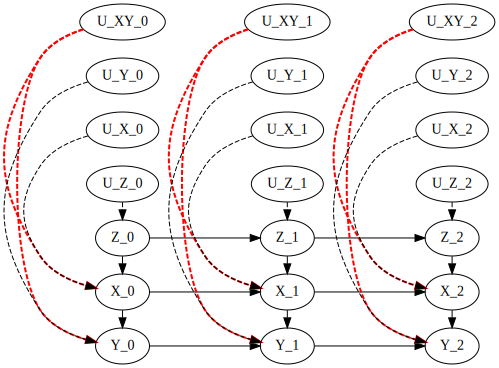

In [4]:
T = 3
graph_view = make_graphical_model(0,
T-1,
topology='dependent',
target_node='Y',
node_information= node_info,
confounder_info=conf_info,
verbose=True)
graph_view

In [5]:
background_info = {
    # Exogenous / background conditions
    "U_Z": {"type": "background", "domain": (0, 1)},
    "U_X": {"type": "background", "domain": (0, 1)},
    "U_Y": {"type": "background", "domain": (0, 1)},
    "U_XY": {"type": "confounder", "domain": (0, 1)},
}
# Contains all the sub-graphs per time-slice
G = make_networkx_object(graph_view, node_info | background_info, T)
# TODO: add assigned variable edges here but make sure that they are removed from the relevant node if that variable is intervened upon.
gs = get_time_slice_sub_graphs(G,T)
cds = make_time_slice_causal_diagrams(gs,conf_info)

## Explore SCM from fig 3

In [8]:
SEM = DynamicIVCD()
static = SEM.static()
dynamic = SEM.dynamic()

T = 3
N = 10
exo_vars = {"U_Z": ber.rvs(p=0.6, size=(N,T)), "U_X":ber.rvs(p=0.11, size=(N,T)), "U_Y":ber.rvs(p=0.15, size=(N,T)) ,"U_XY":ber.rvs(p=0.51, size=(N,T))}

In [6]:
params = setup_DynamicIVCD()
m = CCB(**params)
temporal_index = 0
target = m.all_target_variables[temporal_index]
# Check that indices line up for this time-slice
target_var_only, target_var_temporal_index = target.split("_")
assert int(target_var_temporal_index) == temporal_index
SEM = testSEM()

# Create SCM
scm = StructuralCausalModel(
    G=m.causal_diagrams[temporal_index],
    F=SEM,
    P_U=m.P_U,
    D=m.domains,
    more_U=m.more_U,
)
print(m.arm_strategy)

#  Convert time-slice SCM to bandit machine
print("old")
mu, arm_setting = SCM_to_bandit_machine(scm, target_variable=target_var_only)
#  Select arm strategy, one of: "POMIS", "MIS", "Brute-force", "All-at-once"
arm_selected = arms_of(m.arm_strategy, arm_setting, scm.G, target_var_only)
print(mu, arm_setting, arm_selected)
print("new")
mu, arm_setting = new_SCM_to_bandit_machine(scm, reward_variable='Y')
#  Select arm strategy, one of: "POMIS", "MIS", "Brute-force", "All-at-once"
arm_selected = arms_of(m.arm_strategy, arm_setting, scm.G, target_var_only)
print(mu, arm_setting, arm_selected)

POMIS
old
(0.4454, 0.493, 0.5070000000000001, 0.773, 0.22700000000000004, 0.493, 0.493, 0.5070000000000001, 0.5070000000000001) {0: {}, 1: {'X': 0}, 2: {'X': 1}, 3: {'Z': 0}, 4: {'Z': 1}, 5: {'X': 0, 'Z': 0}, 6: {'X': 0, 'Z': 1}, 7: {'X': 1, 'Z': 0}, 8: {'X': 1, 'Z': 1}} (1, 2, 3, 4)
new
(0.4454, 0.493, 0.5070000000000001, 0.773, 0.22700000000000004, 0.493, 0.493, 0.5070000000000001, 0.5070000000000001) {0: {}, 1: {'X': 0}, 2: {'X': 1}, 3: {'Z': 0}, 4: {'Z': 1}, 5: {'X': 0, 'Z': 0}, 6: {'X': 0, 'Z': 1}, 7: {'X': 1, 'Z': 0}, 8: {'X': 1, 'Z': 1}} (1, 2, 3, 4)


In [7]:
temporal_index = 1 # <----------------------
target = m.all_target_variables[temporal_index]
# Check that indices line up for this time-slice
target_var_only, target_var_temporal_index = target.split("_")
assert int(target_var_temporal_index) == temporal_index
SEM = testSEM()

# Create SCM
scm = StructuralCausalModel(
    G=m.causal_diagrams[temporal_index],
    F=SEM,
    P_U=m.P_U,
    D=m.domains,
    more_U=m.more_U,
)

#  Convert time-slice SCM to bandit machine
past_interventions = [{"Z":0}]
mu, arm_setting = new_SCM_to_bandit_machine(scm, interventions=past_interventions, reward_variable=target_var_only)
# Select arm strategy, one of: "POMIS", "MIS", "Brute-force", "All-at-once"
arm_selected = arms_of(m.arm_strategy, arm_setting, scm.G, target_var_only)

print(mu, arm_setting, arm_selected)

(0.5518000000000002, 0.5490000000000003, 0.5546, 0.5518000000000002, 0.5518000000000002, 0.5490000000000003, 0.5490000000000003, 0.5546, 0.5546) {0: {}, 1: {'X': 0}, 2: {'X': 1}, 3: {'Z': 0}, 4: {'Z': 1}, 5: {'X': 0, 'Z': 0}, 6: {'X': 0, 'Z': 1}, 7: {'X': 1, 'Z': 0}, 8: {'X': 1, 'Z': 1}} (1, 2, 3, 4)


In [8]:
temporal_index = 2 # <----------------------
target = m.all_target_variables[temporal_index]
# Check that indices line up for this time-slice
target_var_only, target_var_temporal_index = target.split("_")
assert int(target_var_temporal_index) == temporal_index
SEM = testSEM()

# Create SCM
scm = StructuralCausalModel(
    G=m.causal_diagrams[temporal_index],
    F=SEM,
    P_U=m.P_U,
    D=m.domains,
    more_U=m.more_U,
)

#  Convert time-slice SCM to bandit machine
past_interventions = [{"Z":0}, {"Z":0}]
mu, arm_setting = new_SCM_to_bandit_machine(scm, interventions=past_interventions, reward_variable=target_var_only)
# Select arm strategy, one of: "POMIS", "MIS", "Brute-force", "All-at-once"
arm_selected = arms_of(m.arm_strategy, arm_setting, scm.G, target_var_only)

print(mu, arm_setting, arm_selected)

(0.5272222222222226, 0.525666666666667, 0.5287777777777781, 0.5272222222222226, 0.5272222222222226, 0.525666666666667, 0.525666666666667, 0.5287777777777781, 0.5287777777777781) {0: {}, 1: {'X': 0}, 2: {'X': 1}, 3: {'Z': 0}, 4: {'Z': 1}, 5: {'X': 0, 'Z': 0}, 6: {'X': 0, 'Z': 1}, 7: {'X': 1, 'Z': 0}, 8: {'X': 1, 'Z': 1}} (1, 2, 3, 4)


# Test Non-Stationary (piece-wise stationary) SCM-MAB a.k.a. CCB

In [9]:
params = setup_DynamicIVCD(12)
m = CCB(**params)
m.run()

Time index:   0%|          | 0/12 [00:00<?, ?it/s]

[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    1.9s
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    1.9s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    1.9s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    1.9s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    1.9s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    1.9s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    1.9s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    2.0s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    2.0s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    2.0s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    2.0s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    2.0s
[Parallel(n_jobs=7)]: Done  13 tasks      | elapsed:    2.0s
[Parallel(n_jobs=7)]: Done  14 tasks      | elapsed:    2.0s
[Parallel(n_jobs=7)]: Done  15 tasks      | elapsed:    2.1s
[Parallel(

Time index:   8%|▊         | 1/12 [00:02<00:32,  2.95s/it]

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.06009697914123535s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  

Time index:  17%|█▋        | 2/12 [00:04<00:18,  1.83s/it]

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.06062602996826172s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  

Time index:  25%|██▌       | 3/12 [00:05<00:13,  1.47s/it]

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.059806108474731445s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 

Time index:  33%|███▎      | 4/12 [00:06<00:10,  1.31s/it]

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.061318159103393555s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 

Time index:  42%|████▏     | 5/12 [00:07<00:08,  1.22s/it]

[Parallel(n_jobs=7)]: Done  95 out of 100 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.06227588653564453s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.1s
[Parallel

Time index:  50%|█████     | 6/12 [00:08<00:06,  1.16s/it]

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.06099510192871094s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  

Time index:  58%|█████▊    | 7/12 [00:09<00:05,  1.13s/it]

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.061543941497802734s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 

Time index:  67%|██████▋   | 8/12 [00:10<00:04,  1.11s/it]

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.06427597999572754s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  

Time index:  75%|███████▌  | 9/12 [00:11<00:03,  1.10s/it]

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.06407618522644043s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  

Time index:  83%|████████▎ | 10/12 [00:12<00:02,  1.10s/it]

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.060122013092041016s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done 

Time index:  92%|█████████▏| 11/12 [00:13<00:01,  1.09s/it]

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=7)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=7)]: Done   1 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Batch computation too fast (0.07545280456542969s.) Setting batch_size=2.
[Parallel(n_jobs=7)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   3 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   4 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   5 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   6 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   7 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   8 tasks      | elapsed:    0.1s
[Parallel(n_jobs=7)]: Done   9 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done  10 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done  11 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done  12 tasks      | elapsed:    0.2s
[Parallel(n_jobs=7)]: Done  

Time index: 100%|██████████| 12/12 [00:14<00:00,  1.22s/it]

[Parallel(n_jobs=7)]: Done 100 out of 100 | elapsed:    0.9s finished


In [10]:
m.reward_distribution

{0: (0.4454,
  0.493,
  0.5070000000000001,
  0.773,
  0.22700000000000004,
  0.493,
  0.493,
  0.5070000000000001,
  0.5070000000000001),
 1: (0.5518000000000002,
  0.5490000000000003,
  0.5546,
  0.5518000000000002,
  0.5518000000000002,
  0.5490000000000003,
  0.5490000000000003,
  0.5546,
  0.5546),
 2: (0.49900000000000017,
  0.5370000000000003,
  0.5390000000000001,
  0.49900000000000017,
  0.5770000000000002,
  0.5370000000000003,
  0.5370000000000003,
  0.5390000000000001,
  0.5390000000000001),
 3: (0.547727272727273,
  0.5464545454545456,
  0.5490000000000003,
  0.547727272727273,
  0.547727272727273,
  0.5464545454545456,
  0.5464545454545456,
  0.5490000000000003,
  0.5490000000000003),
 4: (0.5204400000000002,
  0.5340666666666669,
  0.5359333333333336,
  0.49860000000000027,
  0.5714000000000004,
  0.5340666666666669,
  0.5340666666666669,
  0.5359333333333336,
  0.5359333333333336),
 5: (0.5556315789473685,
  0.5548947368421053,
  0.5563684210526317,
  0.5556315789473685